# Simple CNN for Classification with PyTorch

เราจะมาลองสร้าง CNN ขนาดเล็ก สำหรับ classification

ขั้นตอนในการสร้างโมเดล
1. data preparation
2. load data
3. define model architecture
4. train model
5. print model's weight
6. mode evaluation

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

ตรวจสอบว่ามี GPU หรือไม่ ถ้ามี ให้ตั้งค่า device เป็น GPU  

In [2]:
# Check for CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## **DATA PREPARATION**
- **สร้างภาพสองภาพ**: หนึ่งสำหรับสี่เหลี่ยมจัตุรัสและอีกหนึ่งสำหรับสามเหลี่ยม<br>
แต่ละภาพควรมีขนาด 4x4 พิกเซลโดยมีค่าตามที่แสดงด้านล่าง<br>
จากนั้นซ้อนภาพในเทนเซอร์แบบ `torch.tensor([<square tensor>,<triangle tensor>])`.

- **สร้าง label**: ให้ตรงกับแต่ละภาพ โดยใช้ 1 สำหรับสี่เหลี่ยมจัตุรัสและ 0 สำหรับสามเหลี่ยม<br>

In [3]:
### START CODE HERE ###
square = [[[1,1,1,1],
          [1,5,5,1],
          [1,5,5,1],
          [1,1,1,1]]]
triangle = [[[1,1,1,5],
            [1,1,5,5],
            [1,5,5,5],
            [5,5,5,5]]]

tensor_square = torch.tensor(square)
tensor_triangle = torch.tensor(triangle)

labels_square = torch.tensor([1])
labels_triangle = torch.tensor([0])

data_tensors = torch.stack([tensor_square, tensor_triangle])
data_labels = torch.stack([labels_square, labels_triangle])

### END CODE HERE ###

จากนั้นแสดงภาพที่สร้างขึ้นโดยใช้ Matplotlib

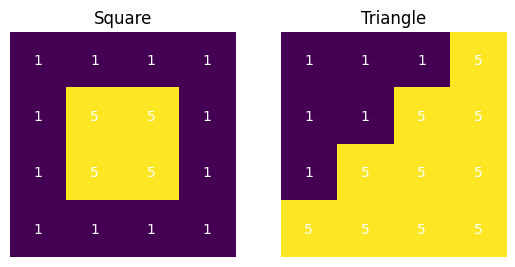

In [4]:
### START CODE HERE ###
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(tensor_square[0])
plt.title('Square')
for i in range(tensor_square.shape[1]):
    for j in range(tensor_square.shape[2]):
        plt.text(j, i, tensor_square[0, i, j].item(), ha='center', va='center', color='white')

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(tensor_triangle[0])
plt.title('Triangle')
for i in range(tensor_triangle.shape[1]):
    for j in range(tensor_triangle.shape[2]):
        plt.text(j, i, tensor_triangle[0, i, j].item(), ha='center', va='center', color='white')

plt.show()
### END CODE HERE ###

ถ้าโค๊ดที่เขียนมาถูกต้อง เซลล์นี้จะทำงานได้โดยไม่มีปัญหา

In [5]:
assert data_tensors.shape == torch.Size([2, 1, 4, 4])
assert data_labels.shape == torch.Size([2, 1])
print("You have successfully created the data_tensors!")

You have successfully created the data_tensors!


## DataLoader
ใช้สำหรับโหลดข้อมูล

In [ ]:
### START CODE HERE ###
dataset = torch.utils.data.TensorDataset(data_tensors, data_labels)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=True)
### END CODE HERE ###

## **Define Model Architecture**
**Create simpleCNN model class using PyTorch.**
- Using `Conv2d()`,`ReLU()`,`Flatten()`,`Linear()`,`Sigmoid()`

กำหนดโครงสร้างของ Model ดังนี้
- ชั้นที่ 1 เป็น Hidden CNN Layer ชั้นที่ 1 ประกอบด้วย <br>
Input (in_channels) = 1   (grayscale image 1 channel) <br>
Output (out_channels) = 2 (Number of Cov nodes = 2 (L1N1, L1N2))<br>
kernel_size = 3           (kernel size 3x3)<br>
stride = 1                (conv every pixel)<br>
padding = 1               (default zero padding)<br>

- ชั้นที่ 2 เป็น Activation Function ของ Conv Layer ชั้นที่ 1 โดยเลือกใช้ ReLU
- ชั้นที่ 3 เป็น Hidden CNN Layer ชั้นที่ 2 ประกอบด้วย <br>
Input (in_channels) = 2   (out_channels จาก CNN Layer ก่อนหน้า) <br>
Output (out_channels) = 2  (Number of Cov nodes = 2 (L2N1, L2N2))<br>
kernel_size = 3           (kernel size 3x3)<br>
stride = 1                (conv every pixel)<br>
padding = 1               (default zero padding)<br>

- ชั้นที่ 4 เป็น Activation Function ของ Cov layer ชั้นที่ 2 โดยเลือกใช้ ReLU เช่นกัน
- ชั้นที่ 5 เป็น flatten เพื่อ reshape to 1D (flatten shape = number of all feature map elements จาก Activation function ก่อนหน้า=4x4x2) <br>
- ชั้นที่ 6 เป็น Hidden Neural Layer ของชั้นที่ 1
ประกอบด้วย <br>
Input (in_channels) = 32   (out จาก flatten)<br>
Output (out_channels) = 2  (Number of NN nodes = 2)<br>
- ชั้นที่ 7 เป็น Activation Function ของ Neural Layer ชั้นที่ 1 โดยเลือกใช้ ReLU เช่นกัน
- ชั้นที่ 8 เป็น Output Layer ประกอบด้วย <br>
Input (in_channels) = 2   (out_channels จาก NN Layer ก่อนหน้า) <br>
Output (out_channels) = 2  (Number of Cov nodes = 2)<br>
- ชั้นที่ 9 เป็น Output Activation Function ของชั้นที่ 2 โดยเลือกใช้ Sigmoid เพื่อให้ได้ผลลัพธ์เป็นค่าในลักษณะของความน่าจะเป็น

สังเกตว่ามิติ (Dimension) ของชั้นที่อยู่ติดกันจะต้องมิติที่เข้ากันได้

เราสามารถสร้างฟังก์ชัน get_features เพื่อใช้ในการดึง Feature map ของแต่ละ conv node ออกมาวิเคราะห์ผลตอบสนองของ Kernel weights กับข้อมูลที่ถูก Forward pass node นั้น หาก Node ใด ไม่ตอบสนองไม่ว่าจะผ่านข้อมูลภาพแบบใด แสดงว่า conv node ไม่มีความจำเป็นกำจัดทิ้งได้ หากต้องการลดขนาดของ Layer หรืออาจจำเป็นต้องทำ Fine tuning เฉพาะ Layer เพิ่มเติม


<img src='https://drive.google.com/uc?id=1zDFNby-xTC2FKlXfNy5lsBNl68UWZvo4'>

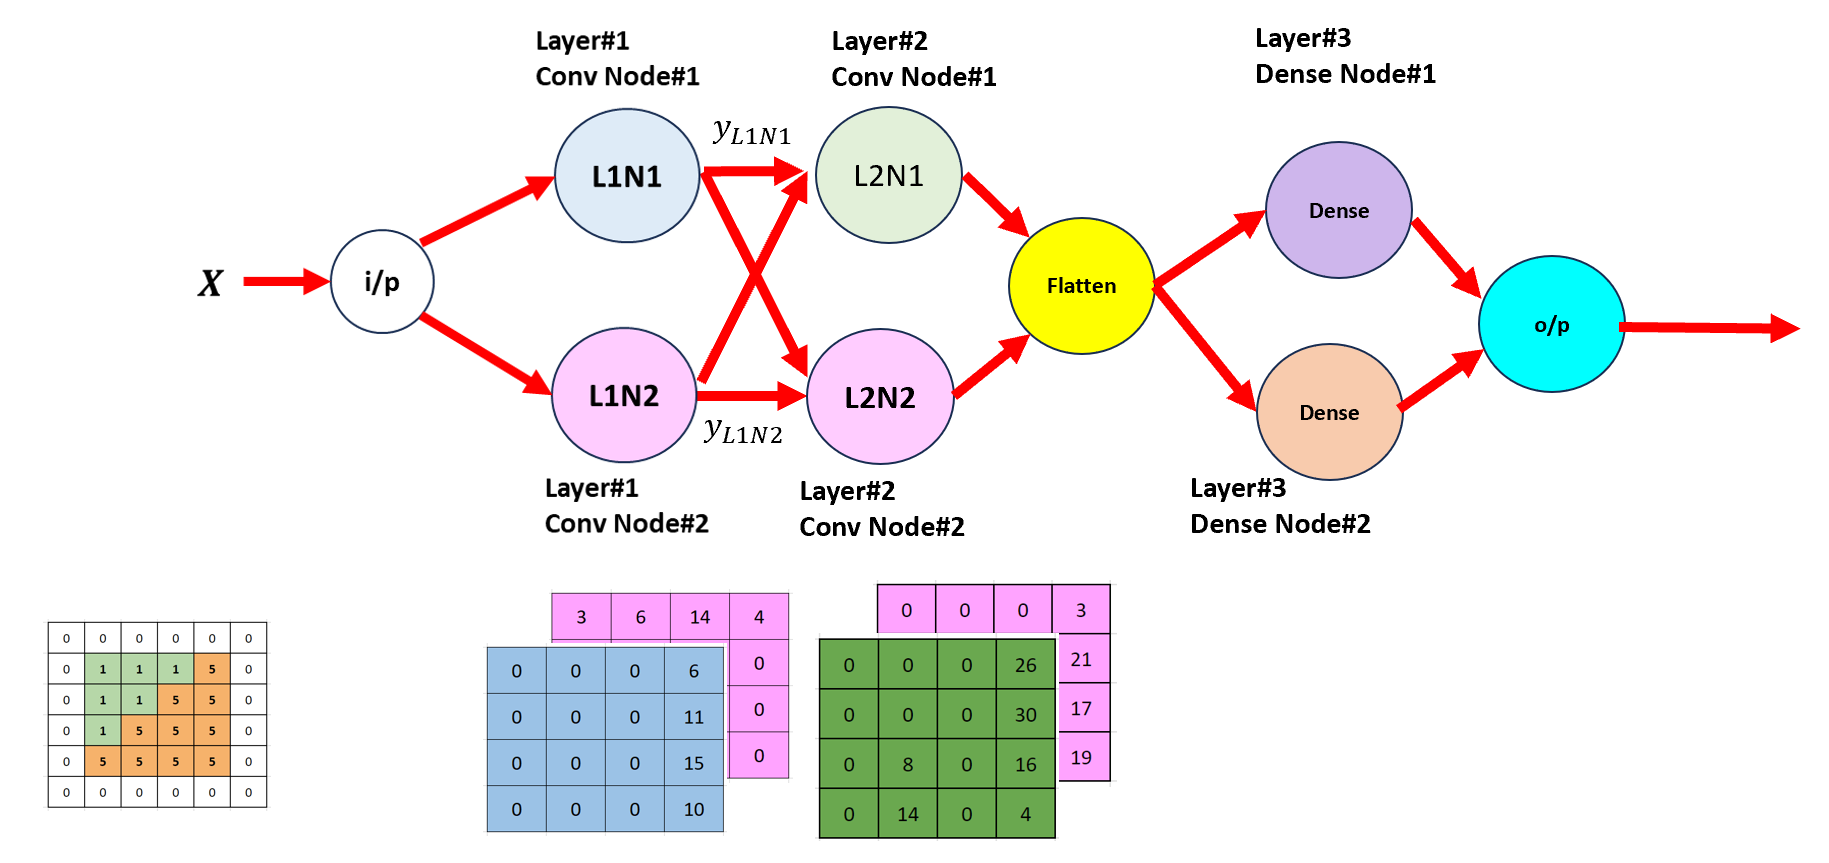

In [7]:
### START CODE HERE ###
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=2, out_channels=2, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(32,2)
        self.relu3 = nn.ReLU()
        self.out = nn.Linear(2,1)
        self.sigmoid = nn.Sigmoid()


    def get_features(self, x):
        """
        Function to get the feature maps of the input
        """
        x = self.conv1(x)
        f1 = self.relu1(x)
        x = self.conv2(f1)
        f2 = self.relu2(x)
        return f1,f2

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = self.relu3(x)
        x = self.out(x)
        x = self.sigmoid(x)
        return x

# Set the random seed for reproducible results
torch.manual_seed(841)
model = SimpleCNN().to(device)
print(model)
### END CODE HERE ###

SimpleCNN(
  (conv1): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=32, out_features=2, bias=True)
  (relu3): ReLU()
  (out): Linear(in_features=2, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


ถ้าการกำหนดโครงสร้างโมเดลถูกต้อง เซลล์นี้จะทำงานได้โดยไม่มีปัญหา

In [8]:
assert model(tensor_triangle.unsqueeze(1).float().to(device)).shape == torch.Size([1, 1])
print("You have successfully implemented a forward pass!")

You have successfully implemented a forward pass!


## **Train the model**

หลังจากกระบวนการเทรน ตามจำนวน Epoch ที่กำหนด ให้แสดงกราฟค่า loss ของโมเดลในแต่ละ epoch

กำหนด loss function และอัลกอรึทึมในการทำ Gradient Descent ในที่นี้จะใช้ Binary Cross Entropy เป็น Loss Function และ Stochastic Gradient Descent ในการหาจุดต่ำสุด กำหนด lr (learning rate) และ จำนวนรอบ epoch ในการ train

ส่วนของการ Train จะทำทั้งหมด 10,000 รอบ
- บรรทัด optimizer.zero_grad() คือการรีเซ็ทค่า gradient ให้เป็น 0 เพื่อจะได้เก็บค่า Loss ใหม่ตั้งแต่ 0 ของแต่ละ iteration
- บรรทัด outputs = model(x) เป็นสั่งให้ทำงานใน forward pass
- บรรทัด loss = criterion(outputs, y) เป็นการนำค่าผลลัพธ์จาก forward pass มาหา Loss
- บรรทัด loss.backward() เป็นการสั่งให้ทำ backward pass ซึ่งจะได้ค่า gradient ของ weight แต่ละตัว
- บรรทัด optimizer.step() คือ การสั่งให้ปรับ weight และ bias ของ training loop นี้

จากนั้นในทุกๆ 100 รอบก็จะพิมพ์ผลมาดูครั้งหนึ่ง (ปรับเป็นค่าอื่นก็ได้)

<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- ผลลัพธ์ควรจะคล้ายกับรูปด้านล่างนี้ แต่ไม่จำเป็นต้องเหมือนกัน

<img src='https://drive.google.com/uc?id=1kK2e8AcD9wV2-_3sG083zSfFukthuhS2'>

</details>

In [9]:
### START CODE HERE ###
epochs = 10000
lr = 0.0028
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
loss_history = []
for epoch in range(epochs):
    for x,y in dataloader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        output = model(x.float())
        loss = criterion(output, y.float())
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
    if (epoch+1) % 100 == 0:
        print(f'[Epoch {epoch+1}] Loss: {loss.item()}')
### END CODE HERE ###

[Epoch 100] Loss: 0.6817154884338379
[Epoch 200] Loss: 0.6611222624778748
[Epoch 300] Loss: 0.6282346844673157
[Epoch 400] Loss: 0.5672623515129089
[Epoch 500] Loss: 0.4785878658294678
[Epoch 600] Loss: 0.39856597781181335
[Epoch 700] Loss: 0.3491181433200836
[Epoch 800] Loss: 0.315512478351593
[Epoch 900] Loss: 0.28158697485923767
[Epoch 1000] Loss: 0.2267603874206543
[Epoch 1100] Loss: 0.13452422618865967
[Epoch 1200] Loss: 0.0633760467171669
[Epoch 1300] Loss: 0.033780522644519806
[Epoch 1400] Loss: 0.021148990839719772
[Epoch 1500] Loss: 0.014553536660969257
[Epoch 1600] Loss: 0.010708310641348362
[Epoch 1700] Loss: 0.008306740783154964
[Epoch 1800] Loss: 0.006662529893219471
[Epoch 1900] Loss: 0.005505356006324291
[Epoch 2000] Loss: 0.004654432646930218
[Epoch 2100] Loss: 0.003999795764684677
[Epoch 2200] Loss: 0.0034895925782620907
[Epoch 2300] Loss: 0.003082637209445238
[Epoch 2400] Loss: 0.002748720347881317
[Epoch 2500] Loss: 0.0024750533048063517
[Epoch 2600] Loss: 0.00224358

แสดงกราฟค่า Loss ทุก epoch ที่บันทึกเก็บไว้

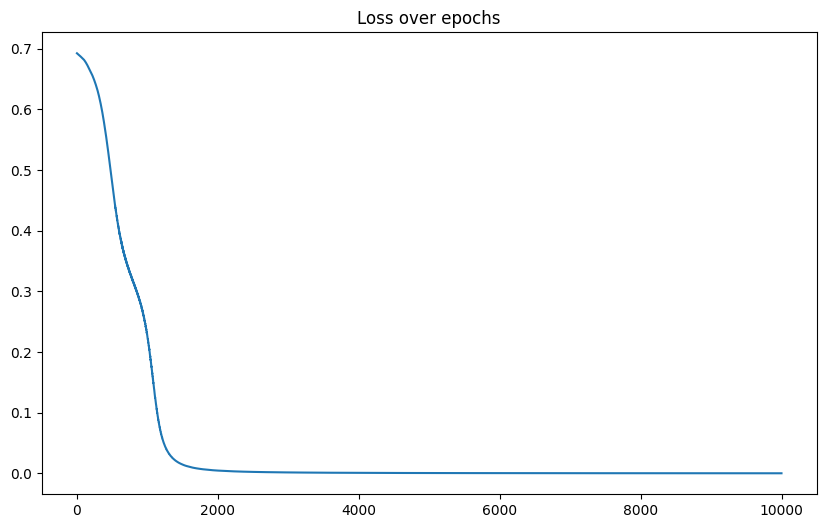

In [10]:
### START CODE HERE ###
plt.figure(figsize=(10, 6))
plt.title('Loss over epochs')
plt.plot(loss_history)
### END CODE HERE ###

## **Print model's weight**

เราสามารถใช้ `torch.save()` เพื่อ save model และ ใช้ model.state_dict() เพื่อเข้าถึง dictionary ของ array ของ weights (ค่าสัมประสิทธิใน kernel mask) และ bias ของแต่ละ node จะเรียงตามลำดับ layer กำกับด้วยชื่อ layer.parameter  

<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- ผลลัพธ์ควรจะคล้ายกับนี้ แต่ไม่จำเป็นต้องเหมือนกัน

```
OrderedDict([('conv1.weight',
              tensor([...], device='cuda:0')),
             ('conv1.bias', tensor([...], device='cuda:0')),
             ('conv2.weight',
              ...
             ('out.weight', tensor([...], device='cuda:0')),
             ('out.bias', tensor([...], device='cuda:0'))])
```

</details>

In [16]:
### START CODE HERE ###
torch.save(model.state_dict(), 'model.pth')
model.state_dict()
### END CODE HERE ###

OrderedDict([('conv1.weight',
              tensor([[[[ 0.4178,  0.3936,  0.0348],
                        [ 0.1918, -0.3002, -0.3480],
                        [ 0.0229, -0.1447, -0.0315]]],
              
              
                      [[[-0.1744,  0.0069,  0.2229],
                        [ 0.3050,  0.4549,  0.2327],
                        [-0.1438,  0.4869,  0.5488]]]], device='cuda:0')),
             ('conv1.bias', tensor([-0.1141,  0.1048], device='cuda:0')),
             ('conv2.weight',
              tensor([[[[ 0.1378,  0.0572, -0.3133],
                        [-0.1260, -0.0546, -0.3380],
                        [-0.1682, -0.1877, -0.0948]],
              
                       [[-0.0245,  0.2931,  0.3160],
                        [ 0.2575,  0.5127,  0.3996],
                        [-0.0087,  0.1811,  0.2367]]],
              
              
                      [[[-0.0150, -0.0864, -0.0030],
                        [-0.0923,  0.0210,  0.1223],
                      

### **แสดง Feature map ของฟิลเตอร์แต่ละตัวของโมเดลด้วยข้อมูลอินพุต 2 คลาส**

- Use `.get_features()`

<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- ผลลัพธ์ควรจะคล้ายกับนี้ แต่ไม่จำเป็นต้องเหมือนกัน

<img src='https://drive.google.com/uc?
id=1OU9L8-jWcre5fAV5tuIWgzIBZot9VCbU'>

</details>

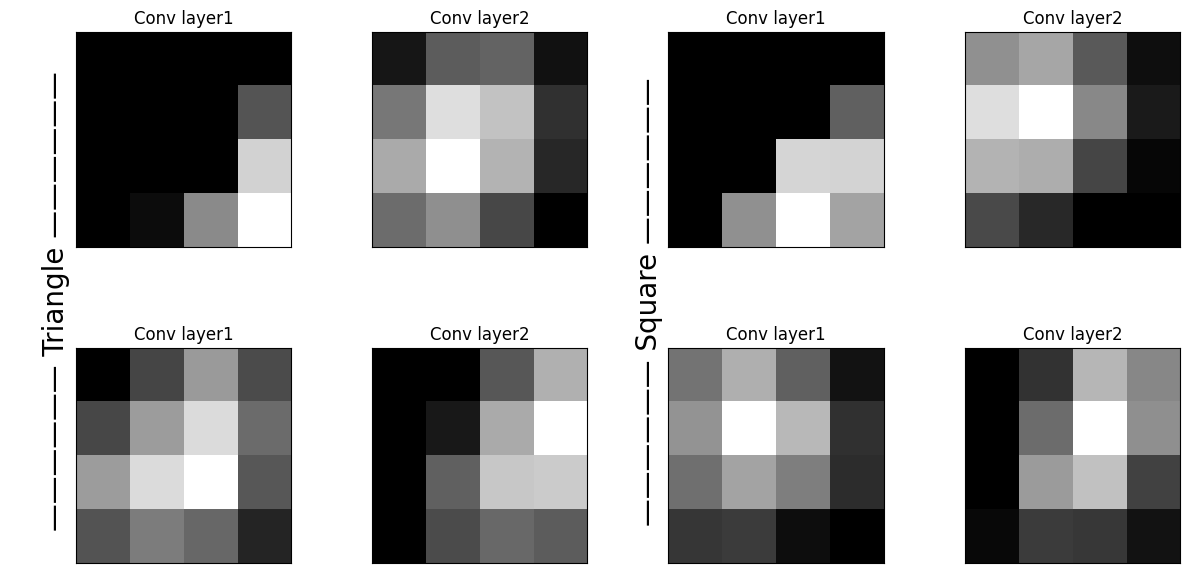

In [17]:
### START CODE HERE ###

conv1_triangle, conv2_triangle = model.get_features(tensor_triangle.unsqueeze(1).float().to(device))
conv1_square, conv2_square = model.get_features(tensor_square.unsqueeze(1).float().to(device))

plt.figure(figsize=(12, 6))

feature_maps = [conv1_triangle, conv2_triangle, conv1_square, conv2_square]
titles = ['Conv layer1', 'Conv layer2']

for i, feature_map in enumerate(feature_maps):

    plt.subplot(2, 4, i + 1)
    # plt.axis('off')
    plt.xticks([])
    plt.yticks([])
    plt.imshow(feature_map[0, 0].squeeze().cpu().detach().numpy(), cmap='gray')
    if i == 0:
        plt.ylabel('\n—————— Triangle ——————', fontsize=20,y=-0.25)
    elif i == 2:
        plt.ylabel('\n—————— Square ——————', fontsize=20,y=-0.25)
    plt.title(titles[i%2!=0])

    plt.subplot(2, 4, i + 5)
    # plt.axis('off')
    plt.xticks([])
    plt.yticks([])
    plt.imshow(feature_map[0, 1].squeeze().cpu().detach().numpy(), cmap='gray')
    plt.title(titles[i%2!=0])
plt.tight_layout()
plt.show()

### END CODE HERE ###

## **Model Evaluation.**

- **สร้างภาพสองภาพ:** หนึ่งสำหรับสี่เหลี่ยมและอีกหนึ่งสำหรับสามเหลี่ยม<br>
แต่ละภาพควรมีขนาด 4x4 พิกเซลด้วยค่าตามที่แสดงด้านล่าง<br>
จากนั้นนำมันมาซ้อนเป็นเทนเซอร์เช่น `torch.tensor([<square tensor>,<triangle tensor>])`.

- **สร้าง label**: ให้ตรงกับแต่ละภาพ โดยใช้ 1 สำหรับสี่เหลี่ยมจัตุรัสและ 0 สำหรับสามเหลี่ยม<br>

จากนั้นแสดงภาพตามที่แสดงด้านล่าง

<img src='https://drive.google.com/uc?
id=1qJU3YhfSDrZQ0owEjLODr5QoPwkjKI8Z'>


In [26]:
### START CODE HERE ###
model.load_state_dict(torch.load('model.pth'))
### END CODE HERE ###

<All keys matched successfully>

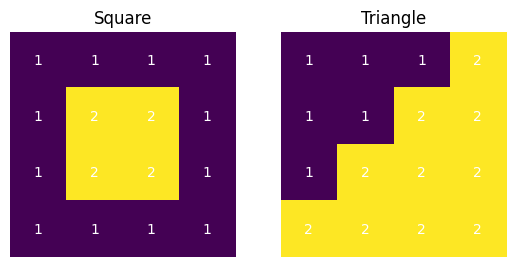

In [27]:
### START CODE HERE ###
square_test = [[[1,1,1,1],
          [1,2,2,1],
          [1,2,2,1],
          [1,1,1,1]]]
triangle_test = [[[1,1,1,2],
            [1,1,2,2],
            [1,2,2,2],
            [2,2,2,2]]]

tensor_square_test = torch.tensor(square_test)
tensor_triangle_test = torch.tensor(triangle_test)

labels_square_test = torch.tensor([1])
labels_triangle_test = torch.tensor([0])

test_data_tensors = torch.stack([tensor_square_test, tensor_triangle_test])
test_data_labels = torch.stack([labels_square_test, labels_triangle_test])

plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(tensor_square_test[0])
plt.title('Square')
for i in range(tensor_square_test.shape[1]):
    for j in range(tensor_square_test.shape[2]):
        plt.text(j, i, tensor_square_test[0, i, j].item(), ha='center', va='center', color='white')

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(tensor_triangle_test[0])
plt.title('Triangle')
for i in range(tensor_triangle_test.shape[1]):
    for j in range(tensor_triangle_test.shape[2]):
        plt.text(j, i, tensor_triangle_test[0, i, j].item(), ha='center', va='center', color='white')

plt.show()
### END CODE HERE ###

If your code is correct, this cell will execute without any issues.

In [20]:
assert data_tensors.shape == torch.Size([2, 1, 4, 4])
assert data_labels.shape == torch.Size([2, 1])
print("You have successfully created the data_tensors!")

You have successfully created the data_tensors!


**Show feature maps of each model's filters with 2 classes of test data.**

- Use `.get_features()`

<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical.

<img src='https://drive.google.com/uc?
id=1rcDBQq43Ujxj5m8EZLWylWxeeiASK9ey'>

</details>

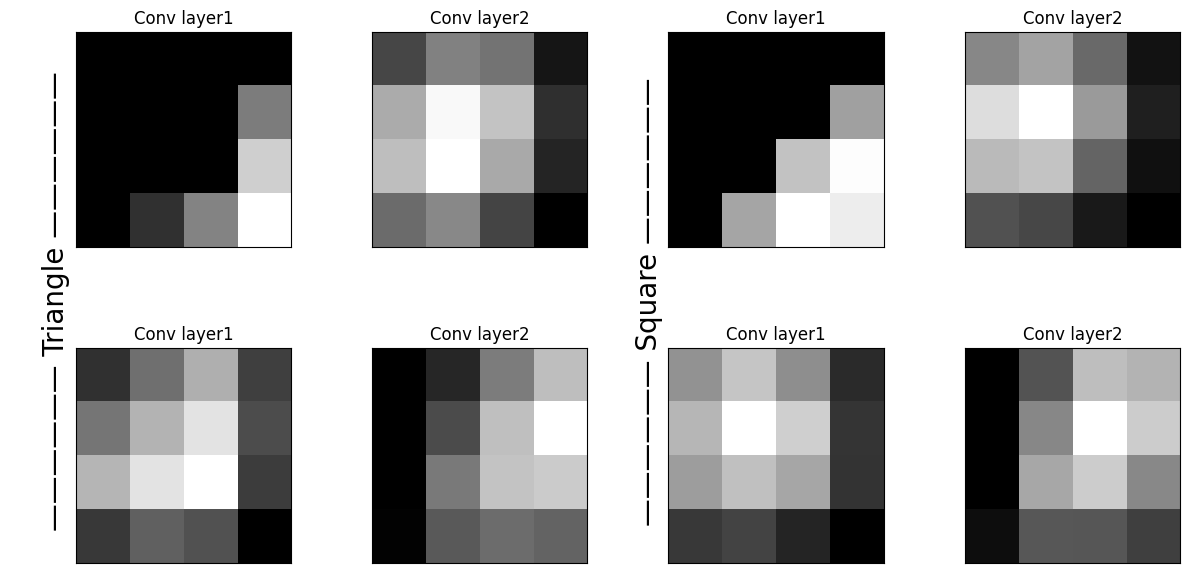

In [21]:
### START CODE HERE ###
conv1_triangle, conv2_triangle = model.get_features(tensor_triangle_test.unsqueeze(1).float().to(device))
conv1_square, conv2_square = model.get_features(tensor_square_test.unsqueeze(1).float().to(device))

plt.figure(figsize=(12, 6))

feature_maps = [conv1_triangle, conv2_triangle, conv1_square, conv2_square]
titles = ['Conv layer1', 'Conv layer2']

for i, feature_map in enumerate(feature_maps):
    plt.subplot(2, 4, i + 1)
    # plt.axis('off')
    plt.xticks([])
    plt.yticks([])
    plt.imshow(feature_map[0, 0].squeeze().cpu().detach().numpy(), cmap='gray')
    if i == 0:
        plt.ylabel('\n—————— Triangle ——————', fontsize=20,y=-0.25)
    elif i == 2:
        plt.ylabel('\n—————— Square ——————', fontsize=20,y=-0.25)
    plt.title(titles[i%2!=0])

    plt.subplot(2, 4, i + 5)
    # plt.axis('off')
    plt.xticks([])
    plt.yticks([])
    plt.imshow(feature_map[0, 1].squeeze().cpu().detach().numpy(), cmap='gray')
    plt.title(titles[i%2!=0])
plt.tight_layout()
plt.show()
### END CODE HERE ###

### **การประเมิน model โดยใช้ confusion matrix**

ในการประเมิน model จะมีอยู่ด้วยกันหลายวิธีการ วิธีการหนึ่งเรียกว่า confusion matrix ซึ่งมักจะใช้กับงานที่เป็น Classification วิธีการ คือ นำผลการทำนาย กับ label หรือข้อมูลจริงทุกข้อมูล มาเทียบกัน และ plot เป็น matrix ซึ่งข้อมูลที่ทำนายถูกต้องจะอยู่ตรงเส้นทะแยงมุม และจะทำให้เห็นว่าข้อมูลที่ผิด มักจะผิดที่ตัวใดบ้าง ซึ่งอาจจะนำข้อมูลนี้มาปรับปรุงโมเดลต่อไป

นอกเหนือจากการใช้ confusion matrix ก็จะมีการประเมินต่างๆ ที่ควรจะรู้จักดังนี้
- Precision (ความแม่นยำ): เปอร์เซ็นต์ของตัวอย่างที่ทำนายว่าเป็นบวกที่เป็นบวกจริง คำนวณจาก $\frac{True Positives} { (True Positives+False Positives)}$

- Recall (ความครอบคลุม): เปอร์เซ็นต์ของตัวอย่างบวกที่ถูกทำนายถูกต้อง คำนวณจาก $\frac{True Positives} { (True Positives+False Negatives)}$

- F1-Score: ค่าคะแนนที่เป็น Harmonic Mean ระหว่าง Precision และ Recall คำนวณจาก $\frac{2 (Precision×Recall​)}{(Precision+Recall)}$

<img src=https://miro.medium.com/v2/resize:fit:1334/format:webp/1*3yGLac6F4mTENnj5dBNvNQ.jpeg>

source: "https://miro.medium.com/v2/resize:fit:1334/format:webp/1*3yGLac6F4mTENnj5dBNvNQ.jpeg"

predicted_label: [1. 0.]
true_labels: [1 0]


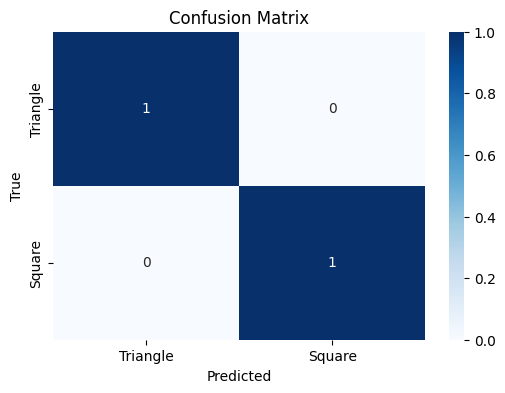

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



In [22]:
### START CODE HERE ###
predictions = model(test_data_tensors.float().to(device))
predicted_labels = (predictions > 0.5).float().cpu().detach().numpy().flatten()
true_labels = test_data_labels.cpu().numpy().flatten()
print('predicted_label:',predicted_labels)
print('true_labels:',true_labels)

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['Triangle', 'Square'], yticklabels=['Triangle', 'Square'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(true_labels, predicted_labels))
### END CODE HERE ###